In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()
from scipy.stats import chi2_contingency

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_curve, auc, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from scipy.stats import shapiro, spearmanr, kendalltau
from scipy.stats import mannwhitneyu, kruskal

import warnings
warnings.filterwarnings('ignore')

2024-03-28 15:18:54.448021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 15:18:54.454912: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 15:18:55.556703: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 15:18:57.607819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 15:19:04.260189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

## Informations Dataset

In [7]:
df=pd.read_csv('labels_df.csv')

In [8]:
df.rename(columns={'race': 'ethnicity'}, inplace=True)

In [9]:
df.head()

,Unnamed: 0,age,gender,ethnicity,date&time
0,0,39,1,0,20170104185638502
1,1,1,1,2,20161219202727078
2,2,50,0,0,20170109010653014
3,3,29,0,0,20170104165350776
4,4,85,0,1,20170111210022765


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22046 entries, 0 to 22045
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  22046 non-null  int64
 1   age         22046 non-null  int64
 2   gender      22046 non-null  int64
 3   ethnicity   22046 non-null  int64
 4   date&time   22046 non-null  int64
dtypes: int64(5)
memory usage: 861.3 KB


In [11]:
nb_doublons = df.duplicated().sum()
print("Nombre de doublons :", nb_doublons)

Nombre de doublons : 0


## Générer des exemples

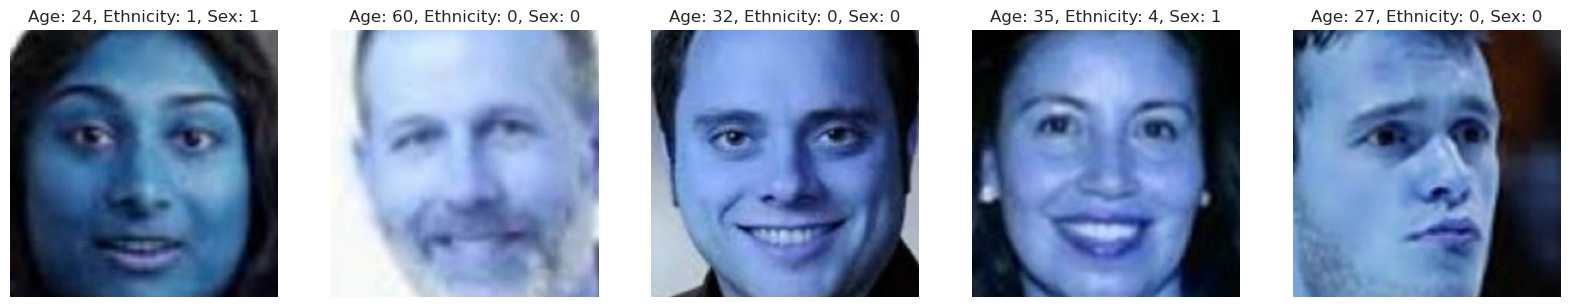

In [15]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    img=mpimg.imread('output_images/image_'+str(random_face)+'.jpg')
    axes[i].imshow(img)
    axes[i].axis('off')

## Data Visualisation

### Variables explicatives

#### Gender

In [16]:
# Valeurs et Nombre de valeurs distinctes
print(df["gender"].unique())
df["gender"].nunique()

[1 0]


2

In [17]:
# Étendue des valeurs, Équilibre
df["gender"].value_counts()

gender
0    11549
1    10497
Name: count, dtype: int64

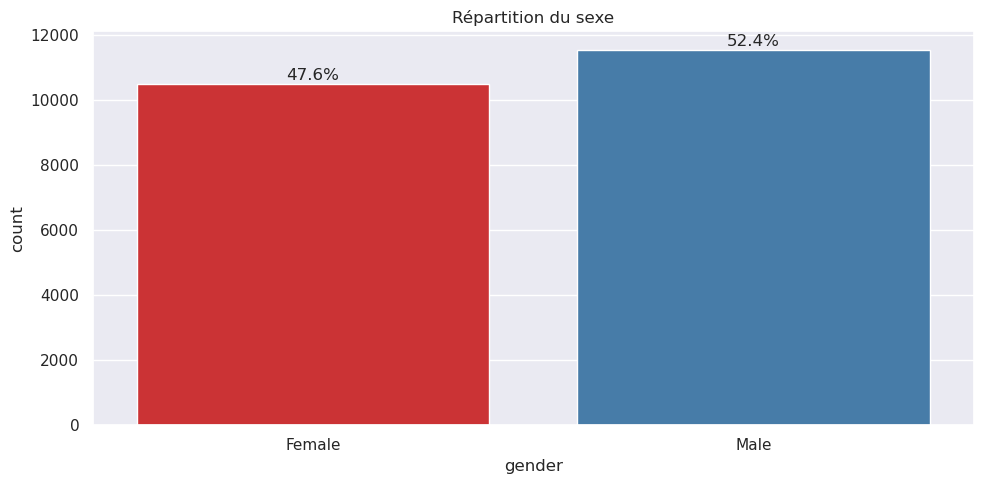

In [18]:
df['gender'] = df['gender'].replace({0: 'Male', 1: 'Female'})
plt.figure(figsize=(10,5))
ax = sns.countplot(x="gender", data=df, palette='Set1', hue='gender', legend=False)  
plt.title("Répartition du sexe")

total = len(df["gender"])
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

#### Ethnicity

In [34]:
# Valeurs et Nombre de valeurs distinctes
df['ethnicity'] = df['ethnicity'].replace({0: 'White', 1: 'Black', 2: 'Asian', 3:'Indian', 4:'Others'})
print(df["ethnicity"].unique())
df["ethnicity"].nunique()

['White' 'Asian' 'Black' 'Others' 'Indian']


5

In [35]:
# Étendue des valeurs, Équilibre
df["ethnicity"].value_counts()

ethnicity
White     9461
Black     4186
Indian    3730
Asian     3113
Others    1556
Name: count, dtype: int64

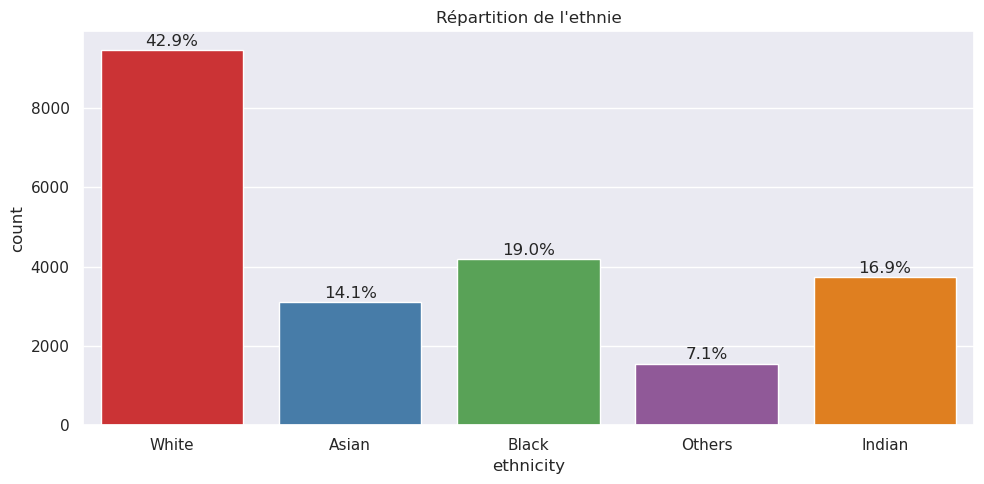

In [36]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="ethnicity", data=df, palette='Set1', hue='ethnicity', legend=False)  
plt.title("Répartition de l'ethnie")

total = len(df["ethnicity"])
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

### Variable Cible: Age

In [37]:
df["age"].describe()

count    22046.000000
mean        33.687653
std         19.693316
min          1.000000
25%         24.000000
50%         30.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [38]:
df['age'].median()

30.0

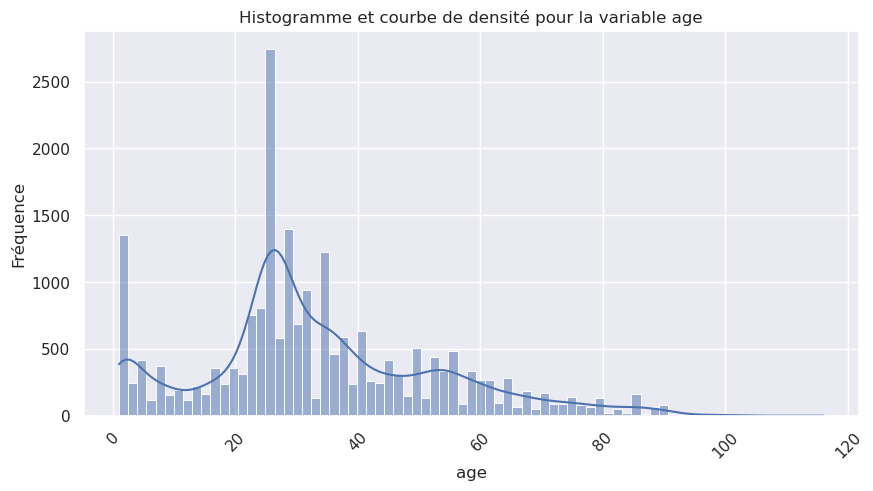

In [39]:
plt.figure(figsize=(10, 5))
df_sorted = df.sort_values('age')
sns.histplot(df_sorted['age'], kde=True)
plt.xlabel('age')
plt.ylabel('Fréquence')
plt.title("Histogramme et courbe de densité pour la variable age")
plt.xticks(rotation=45)  # Modifier cet angle selon tes préférences
plt.show()

In [40]:
# Test de shapiro
stat, p = shapiro(df['age'])

print('Statistique de test :', stat)
print('P-value :', p)

alpha = 0.05
if p > alpha:
    print('La variable est probablement normalement distribuée')
else:
    print('La variable n\'est probablement pas normalement distribuée')

Statistique de test : 0.9576766373533675
P-value : 6.847036947033908e-61
La variable n'est probablement pas normalement distribuée


## Analyse Statistiques

### Tests Statistiques entre une variables qualitative et quantitative

#### Age & Ethnicity

On a procédé au test de Kruskal-Wallis car la variable Age n'est pas normalement distribuée et Ethnicity a plus de deux modalités.

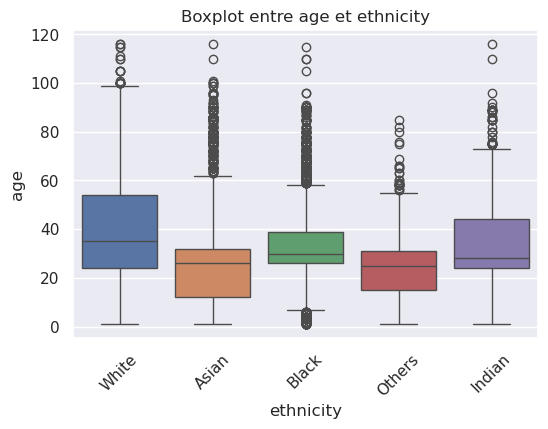

In [41]:
# Graphique de la variable cible en fonction d'ethnicity
plt.figure(figsize=(6, 4))
sns.boxplot(x='ethnicity', y='age', data=df, hue='ethnicity')
plt.xticks(rotation=45)
plt.title('Boxplot entre age et ethnicity')
plt.show()

In [42]:
etats = df['ethnicity'].unique()
data = [df[df['ethnicity'] == etat]['age'] for etat in etats]
statistic, pvalue = kruskal(*data)
print('Statistique du test de Kruskal-Wallis / Ethnicity -> age: ', statistic, ' p-value :', pvalue)

Statistique du test de Kruskal-Wallis / Ethnicity -> age:  1394.2448922097872  p-value : 1.223207252721453e-300


La P-value est inférieure à 0.05 : au moins une des distributions d'ethnicity est différente des autres.

Par contre, ce test n'identifie pas où cette dominance se produit ni pour combien de paires de groupes la dominance s'obtient

#### Age & Gender

On a procédé au test de Mann-Whitney car la variable Age n'est pas normalement distribuée et Gender a exactement deux modalités.

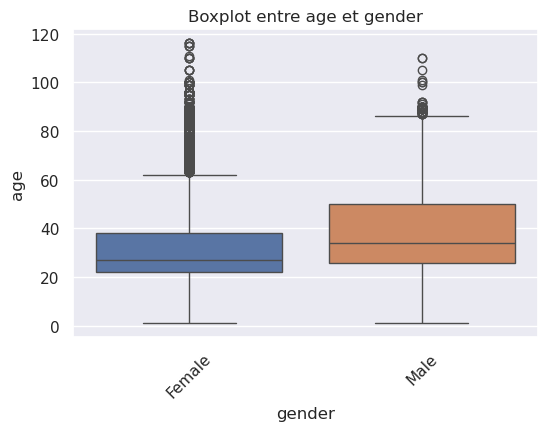

In [43]:
# Graphique de la variable cible en fonction de other_campus_dressing
plt.figure(figsize=(6, 4))
sns.boxplot(x='gender', y='age', data=df, hue='gender')
plt.xticks(rotation=45)
plt.title('Boxplot entre age et gender')
plt.show()

In [44]:
ptypes = df['gender'].unique()
data1 = [df[df['gender'] == ptype]['age'] for ptype in ptypes]
statistic1, pvalue1 = mannwhitneyu(*data1)
print('Statistique du test de Mann-Whitney / gender -> age: ',statistic1, ' p-value :', pvalue1)

Statistique du test de Mann-Whitney / gender -> age:  48548167.5  p-value : 2.274603134444284e-144


La P-value est inférieure à 0.05 : a une différence significative entre les deux genres en termes d'âge.

### Tests Statistiques entre deux variables qualitatives

#### Gender & Ethnicity

Tout d'abord, on commencera par le test chi-carré pour savoir si une association existe entre les deux variables.

En cas d'association, nous procéderons au test de Cramer-V pour savoir si cette association est forte ou non

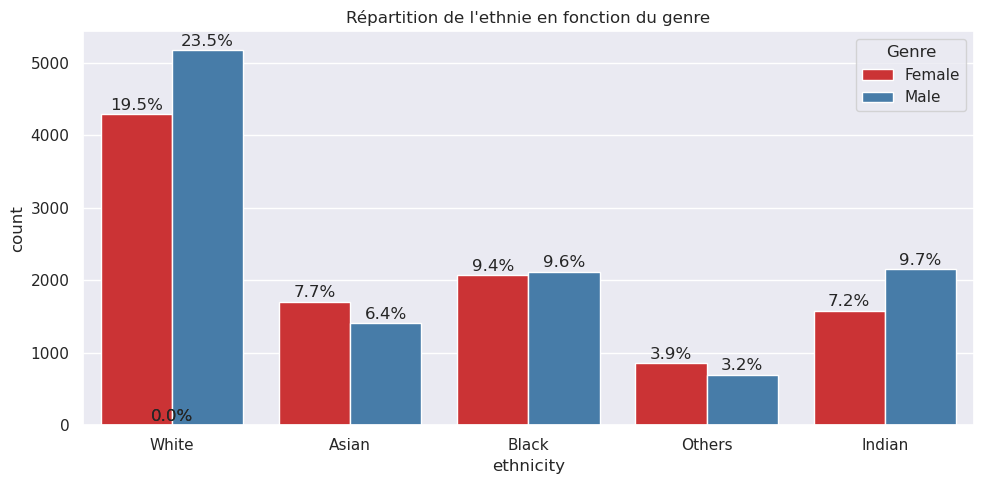

In [45]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x="ethnicity", data=df, palette='Set1', hue='gender')  
plt.title("Répartition de l'ethnie en fonction du genre")

total = len(df["ethnicity"])
for p in ax.patches:
    percentage = f'{100*p.get_height()/total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

# Ajout de la légende pour le genre
plt.legend(title='Genre', loc='upper right')

plt.tight_layout()
plt.show()

In [46]:
# Tableau de contingence des variables
ct = pd.crosstab(df['ethnicity'], df['gender'])
ct

gender,Female,Male
ethnicity,,
Asian,1704,1409
Black,2067,2119
Indian,1581,2149
Others,857,699
White,4288,5173


In [47]:
# Test du chi-carré
chi2_stat, p_value, dof, expected_freq = chi2_contingency(ct)

print("Statistique du test de chi-carré :", chi2_stat)
print("p_value :", p_value)
print("Degrés de liberté :", dof)

Statistique du test de chi-carré : 164.097866732009
p_value : 1.931679416425768e-34
Degrés de liberté : 4


La P-value est inférieure à 0.05 : il y a une association entre les deux variables.

Par contre, il faut calculer le coefficient de Cramer-V pour mesurer la force d'association

In [48]:
# Coefficient de Cramer-V
n = ct.sum().sum()
min_dim = min(ct.shape) - 1
cramer_v = np.sqrt(chi2_stat/(n*min_dim))

# Afficher du résultat
print("Coefficient de Cramer-V :", cramer_v.round(3))

Coefficient de Cramer-V : 0.086


La valeur de Cramer-V est inférieure à 0.6
L'association entre les deux variables est faible.